In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
from datasets import load_dataset
from dataset import BrainTumorDataset
from train import train
import numpy as np
import torch
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2

# Data Loading and Visualization

In [7]:
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
# Convert the dataset to a pandas DataFrame for visualization
df = pd.DataFrame(dataset['train'][:])  # Convert the 'train' split to a DataFrame
df.head()

,file_name,image,id,category_id,bbox,segmentation,area,iscrowd,height,width,date_captured,license
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,1,"[145.0, 239.0, 168.75, 162.5]","[[313.75, 238.75, 145.0, 238.75, 145.0, 401.25...",27421.8750,0,640,640,2023-08-19T04:37:54+00:00,1
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,"[194.0, 176.0, 148.75, 233.75]","[[342.5, 176.25, 193.75, 176.25, 193.75, 410.0...",34770.3125,0,640,640,2023-08-19T04:37:54+00:00,1
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,1,"[133.0, 173.0, 162.5, 185.0]","[[295.0, 172.5, 132.5, 172.5, 132.5, 357.5, 29...",30062.5000,0,640,640,2023-08-19T04:37:54+00:00,1
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,1,"[245.0, 358.0, 138.75, 166.25]","[[383.75, 357.5, 245.0, 357.5, 245.0, 523.75, ...",23067.1875,0,640,640,2023-08-19T04:37:54+00:00,1
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4,1,"[80.0, 189.0, 112.5, 132.5]","[[192.5, 188.75, 80.0, 188.75, 80.0, 321.25, 1...",14906.2500,0,640,640,2023-08-19T04:37:54+00:00,1


In [8]:
df.loc[df["category_id"]!=1]

,file_name,image,id,category_id,bbox,segmentation,area,iscrowd,height,width,date_captured,license
7,1491_jpg.rf.3c658e83538de0fa5a3f4e13d7d85f12.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,7,2,"[350.0, 288.0, 42.5, 52.5]","[[392.5, 287.5, 350.0, 287.5, 350.0, 340.0, 39...",2231.250000,0,640,640,2023-08-19T04:37:54+00:00,1
8,1385_jpg.rf.3c67cb92e2922dba0e6dba86f69df40b.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,2,"[239.0, 250.0, 61.25, 87.5]","[[300.0, 250.0, 238.75, 250.0, 238.75, 337.5, ...",5359.375000,0,640,640,2023-08-19T04:37:54+00:00,1
11,1550_jpg.rf.3d067be9580ec32dbee5a89c675d8459.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,11,2,"[283.0, 270.0, 111.25, 102.5]","[[393.75, 270.0, 282.5, 270.0, 282.5, 372.5, 3...",11403.125000,0,640,640,2023-08-19T04:37:54+00:00,1
16,239_jpg.rf.3dcc0799277fb78a2ab21db7761ccaeb.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,16,2,"[279.0, 236.0, 78.75, 76.25]","[[357.5, 236.25, 278.75, 236.25, 278.75, 312.5...",6004.687988,0,640,640,2023-08-19T04:37:54+00:00,1
17,194_jpg.rf.3e3dd592d034bb5ee27a978553819f42.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17,2,"[286.0, 160.0, 188.75, 166.25]","[[475.0, 160.0, 286.25, 160.0, 286.25, 326.25,...",31379.687500,0,640,640,2023-08-19T04:37:54+00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1492,1825_jpg.rf.fb83ead19918f474d9214b3b4904e602.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1492,2,"[306.0, 209.0, 152.5, 121.25]","[[458.75, 208.75, 306.25, 208.75, 306.25, 330....",18490.625000,0,640,640,2023-08-19T04:37:54+00:00,1
1495,1717_jpg.rf.fdfcd2b5b8366a395f155638cd5bd702.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1495,2,"[269.0, 203.0, 97.5, 105.0]","[[366.25, 202.5, 268.75, 202.5, 268.75, 307.5,...",10237.500000,0,640,640,2023-08-19T04:37:54+00:00,1
1496,1244_jpg.rf.feaf45cfe2818c1c141d9d517cdec240.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1496,2,"[278.0, 236.0, 100.0, 82.5]","[[377.5, 236.25, 277.5, 236.25, 277.5, 318.75,...",8250.000000,0,640,640,2023-08-19T04:37:54+00:00,1
1497,1365_jpg.rf.fe6ceef68f802f62e68bfe86cbedf4c0.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1497,2,"[194.0, 264.0, 106.25, 122.5]","[[300.0, 263.75, 193.75, 263.75, 193.75, 386.2...",13015.625000,0,640,640,2023-08-19T04:37:54+00:00,1


Null values in each column:
No nulls in any column

Summary statistics:
                id  category_id           area  iscrowd  height   width  \
count  1502.000000  1502.000000    1502.000000   1502.0  1502.0  1502.0   
mean    750.250333     1.486684   14964.761207      0.0   640.0   640.0   
std     433.479625     0.499989   10983.874369      0.0     0.0     0.0   
min       0.000000     1.000000      18.750000      0.0   640.0   640.0   
25%     375.250000     1.000000    7195.703247      0.0   640.0   640.0   
50%     750.500000     1.000000   12025.000000      0.0   640.0   640.0   
75%    1124.750000     2.000000   19493.359375      0.0   640.0   640.0   
max    1501.000000     2.000000  128562.500000      0.0   640.0   640.0   

       license  
count   1502.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0  


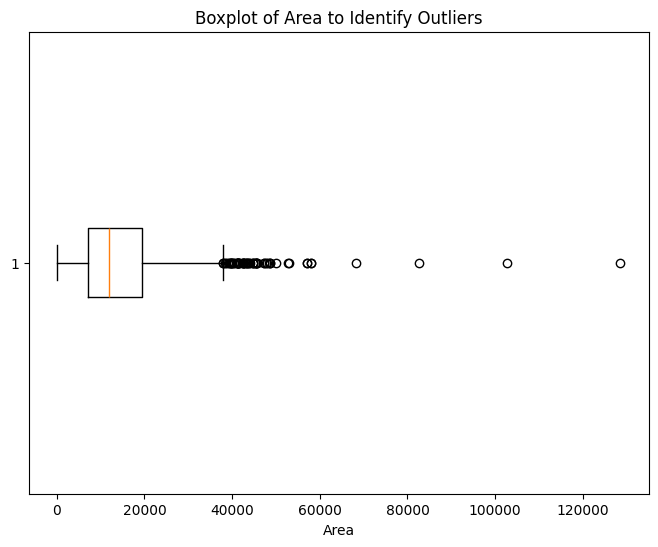

In [9]:
# Check for null values in the DataFrame
print("Null values in each column:")
null_columns = df.columns[df.isnull().any()]
if len(null_columns) > 0:
    print(f"Columns with null values: {list(null_columns)}")
else:
    print("No nulls in any column")

# Summary statistics to identify potential outliers
print("\nSummary statistics:")
print(df.describe())

# Visualize potential outliers in the 'area' column using a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df['area'], vert=False)
plt.title("Boxplot of Area to Identify Outliers")
plt.xlabel("Area")
plt.show()

1


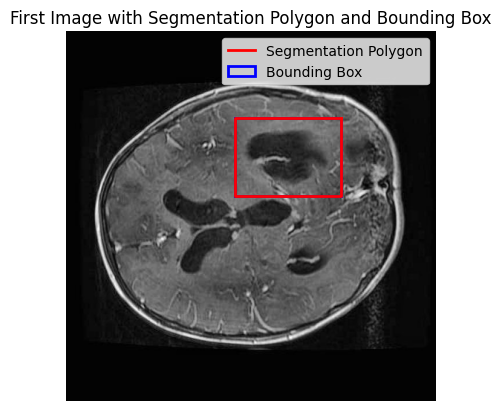

In [10]:
img_num = 5
image = df.iloc[img_num]['image']
segmentation = df.iloc[img_num]['segmentation'][0]
bbox = df.iloc[img_num]['bbox'] 
print(df.iloc[img_num]['category_id'])

fig, ax = plt.subplots(1)
ax.imshow(image)

# segmentation poly
pts = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
ax.plot(pts[:, 0], pts[:, 1], color='r', linewidth=2, label='Segmentation Polygon')

# bounding box
x, y, width, height = bbox
rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='none', label='Bounding Box')
ax.add_patch(rect)

plt.legend()
plt.title("First Image with Segmentation Polygon and Bounding Box")
plt.axis('off')
plt.show()

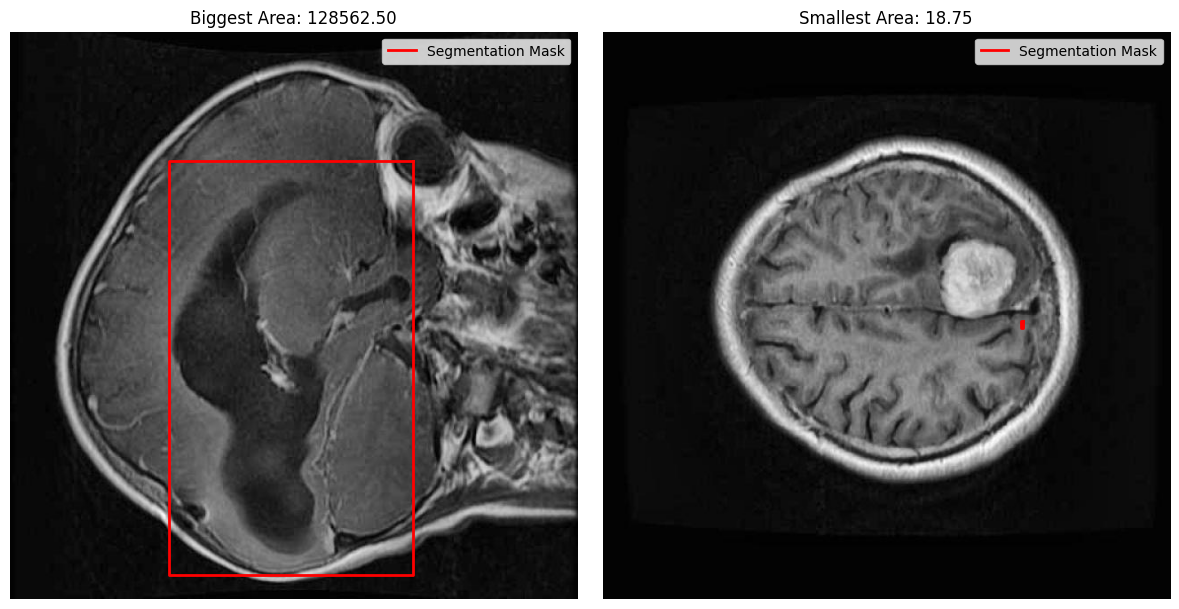

In [11]:
# Find the rows with the biggest and smallest areas
area_rows = df.loc[[df['area'].idxmax(), df['area'].idxmin()]]

# Extract the images and segmentation masks
images = [row['image'] for _, row in area_rows.iterrows()]
segmentations = [np.array(row['segmentation'][0]).reshape(-1, 2) for _, row in area_rows.iterrows()]
areas = area_rows['area'].values
titles = [f"Biggest Area: {areas[0]:.2f}", f"Smallest Area: {areas[1]:.2f}"]

# Plot the images with segmentation masks
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, image, segmentation, title in zip(axes, images, segmentations, titles):
    ax.imshow(image)
    ax.plot(segmentation[:, 0], segmentation[:, 1], color='r', linewidth=2, label='Segmentation Mask')
    ax.set_title(title)
    ax.axis('off')
    ax.legend()

plt.tight_layout()
plt.show()

### Might need to clean the data since the smallest area seems to have been not properly recorded

# Network

In [12]:
from model import ConvTumorDetector
net = ConvTumorDetector()
print(net)

ConvTumorDetector(
  (model): Sequential(
    (0): DownBlock(
      (model): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 32, eps=1e-05, affine=True)
        (5): ReLU()
      )
      (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): DownBlock(
      (model): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(1, 64, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        (5): ReLU()
      )
      (skip): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    )
    (2): DownBlock(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), st

In [ ]:
from torch.utils.data import DataLoader
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")

# load the training dataset
train_dataset = BrainTumorDataset(dataset['train'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for first_image, first_mask in train_loader:
    break

# Load the latest model
model_path = "logs/model_epoch_29.pth"
net.load_state_dict(torch.load(model_path))
net.eval()  # Set the model to evaluation mode

# Make a prediction
with torch.no_grad():
    prediction = net(first_image)

# Prepare data for visualization
predicted_masks = prediction.argmax(dim=1).squeeze().cpu().numpy()  
image_np = first_image.squeeze().permute(1, 2, 0).cpu().numpy()  
ground_truth_masks = first_mask.squeeze().cpu().numpy()  

Prediction shape: torch.Size([1, 2, 640, 640])


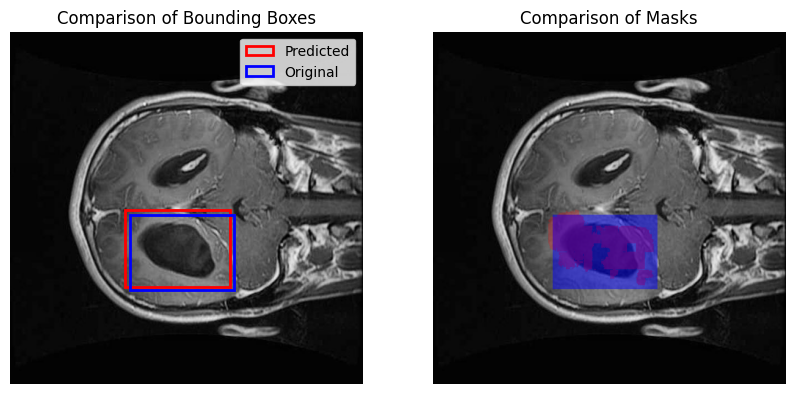

In [81]:
### Plot the image with both bounding boxes
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image_np)

# Plot the predicted bounding box
# Convert the predicted mask to a binary mask
pred_binary_mask = (predicted_masks > 0).astype(np.uint8)
# Find the bounding box using OpenCV
x, y, w, h = cv2.boundingRect(pred_binary_mask)
pred_rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none', label='Predicted')
axs[0].add_patch(pred_rect)

# Repeat process for the original mask
og_binary_mask = (ground_truth_masks > 0).astype(np.uint8)
orig_x, orig_y, orig_w, orig_h = cv2.boundingRect(og_binary_mask)
orig_rect = patches.Rectangle((orig_x, orig_y), orig_w, orig_h, linewidth=2, edgecolor='b', facecolor='none', label='Original')
axs[0].add_patch(orig_rect)
axs[0].legend()
axs[0].set_title("Comparison of Bounding Boxes")
axs[0].set_axis_off()

### Visualize the mask instead of the bounding box
axs[1].imshow(image_np)
# Overlay the predicted mask on the image
overlay = image_np.copy()
overlay[predicted_masks > 0] = [1, 0, 0]   #
axs[1].imshow(overlay, alpha=0.5, label="Predicted Mask")  # Add transparency to the overlay
# original mask
overlay = image_np.copy()
overlay[ground_truth_masks > 0] = [0, 0, 1]  
axs[1].imshow(overlay, alpha=0.5, label="Original Mask")  # Add transparency to the overlay

axs[1].set_title("Comparison of Masks")
plt.axis('off')
plt.show()

C:\Users\humbe\AppData\Local\Temp\ipykernel_27752\142998146.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


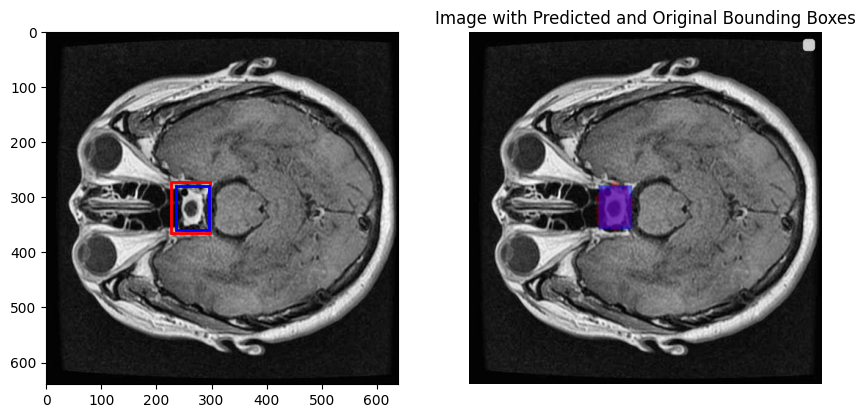

In [ ]:
# # Plot the image with both bounding boxes
# fig, axs = plt.subplots(1, 2, figsize=(10, 10))
# axs[0].imshow(image_np)

# # Plot the predicted bounding box
# # Convert the predicted mask to a binary mask
# binary_mask = (predicted_masks > 0).astype(np.uint8)

# # Find the bounding box using OpenCV
# x, y, w, h = cv2.boundingRect(binary_mask)
# pred_rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none', label='Predicted Bounding Box')
# axs[0].add_patch(pred_rect)

# # Plot the original mask bounding box
# # Convert the predicted mask to a binary mask
# binary_mask = (ground_truth_masks > 0).astype(np.uint8)

# # Find the bounding box using OpenCV
# orig_x, orig_y, orig_w, orig_h = cv2.boundingRect(binary_mask)
# orig_rect = patches.Rectangle((orig_x, orig_y), orig_w, orig_h, linewidth=2, edgecolor='b', facecolor='none', label='Original Bounding Box')
# axs[0].add_patch(orig_rect)


# axs[1].imshow(image_np)
# # Overlay the mask on the image
# overlay = image_np.copy()
# overlay[predicted_masks > 0] = [1, 0, 0]  
# axs[1].imshow(overlay, alpha=0.5)  # Add transparency to the overlay
# # original mask
# overlay = image_np.copy()
# overlay[ground_truth_masks > 0] = [0, 0, 1]  
# axs[1].imshow(overlay, alpha=0.5)  # Add transparency to the overlay


# # Add legend and title
# plt.legend()
# plt.title("Image with Predicted and Original Bounding Boxes")
# plt.axis('off')
# plt.show()